In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.chdir('/Users/Yuval/Desktop/Thesis/COVID-19_data/')

In [3]:
da = pd.read_csv('time_series_covid19_confirmed_global.csv')
da = da.loc[da['Country/Region'] == 'Australia']

In [4]:
states = list(da['Province/State'])
case_numbers = []
for state in states:
    da_temp = da.loc[da['Province/State'] == state]
    da_temp = da_temp.iloc[:,4:]
    case_numbers.append(list(da_temp.iloc[0]))

In [5]:
for c in case_numbers:
    for i in range(1,len(c)):
        if c[i-1] > c[i]:
            print(c[i-1],c[i])

103 102
9553 9429
28510 28472
3035 3033
3092 3089
3110 3109
3117 3115
3151 3150
5084 5083
1139787 1086483
1197969 1197772
1 0
28 27
200 198
202 201
232 231
250 245
253 252
280 278
292 290
307 306
328 313
351 348
1642 1505
25512 18083
29989 29815
33606 33563
35339 35321
37692 37538
3 2
3 2
1034 1033
1052 1051
1061 1056
1088 1087
1150 1149
1172 1171
1225 1224
1233 1232
1311 1309
1492 1491
1764 1763
1771 1770
1956 1955
2090 2089
2109 2106
2117 2116
116892 116879
214602 214577
298367 298194
325151 325150
369936 369807
457 456
560 559
562 561
583 581
597 596
720 719
792 789
972 971
1021 1020
1145 1143
15476 15473
31520 31513
133569 118448
231 230
292 288
32537 30788
20343 20342
20342 20341
20347 20346
20346 20345
20352 20351
20437 20436
20450 20449
20482 20481
20715 20713
999671 974979
553 552
666 641
670 642
854 853
1019 1018
1019 1018
1122 1121
1136 1133
1505 1504
1609 1608
2257 2253
2387 2383
2698 2693
3365 3358
6203 6195
18973 18931


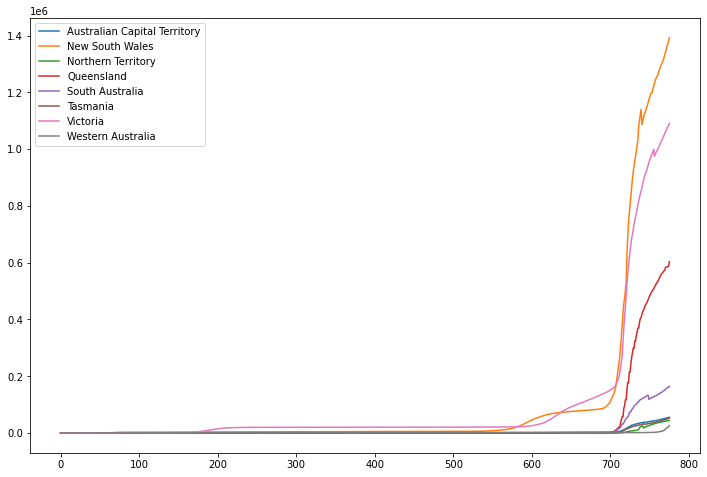

In [6]:
plt.figure(figsize = (12,8))
for c in case_numbers:
    plt.plot(c)
plt.legend(states)

Cool, can remake what Michael did in GetData.jl fairly easily, now let's just look at Adelaide and fit in the compartmental model.

## Adelaide Focus

In [7]:
ad = da.loc[da['Province/State'] == 'South Australia']

In [8]:
ad

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/26/22,2/27/22,2/28/22,3/1/22,3/2/22,3/3/22,3/4/22,3/5/22,3/6/22,3/7/22
13,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,144789,147871,149704,149704,154481,156703,158707,160520,160520,164675


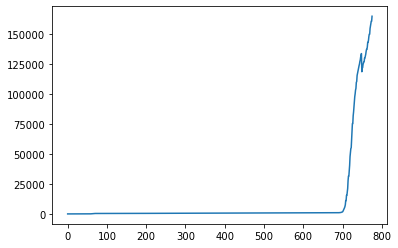

In [9]:
plt.plot(list(ad.iloc[0,4:]))

Or, on a log scale

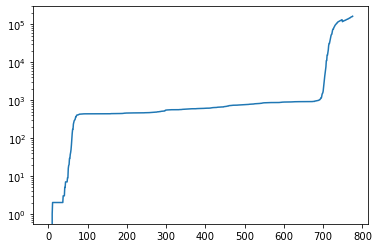

In [10]:
plt.plot(list(ad.iloc[0,4:]))
plt.yscale('log')

Or, focusing on recent outbreak

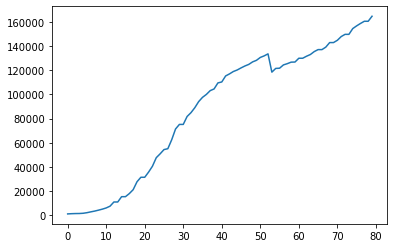

In [11]:
plt.plot(list(ad.iloc[0,700:]))

In [12]:
ad.iloc[0,750:760]

2/6/22     130602
2/7/22     131898
2/8/22     133569
2/9/22     118448
2/10/22    121532
2/11/22    121701
2/12/22    124424
2/13/22    125451
2/14/22    126708
2/15/22    126811
Name: 13, dtype: object

This is what we want to use!

Now import compartmental model, use parameters and fit it on Adelaide.

Omicron reportedly first started in Adelaide on Dec 10th: https://www.sa.gov.au/search?query=omicron&collection=sagov-web-search&x=0&y=0&start_rank=61

Convert the list to number of daily cases

In [13]:
om = ad.iloc[:,691:]
before_om = om.iloc[0,0]
om -= before_om
om

,12/9/21,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,...,2/26/22,2/27/22,2/28/22,3/1/22,3/2/22,3/3/22,3/4/22,3/5/22,3/6/22,3/7/22
13,0,8,25,38,37,74,98,162,160,233,...,143806,146888,148721,148721,153498,155720,157724,159537,159537,163692


In [14]:
totals = list(om.iloc[0])

daily = []
for i in range(1,len(totals)):
    daily.append(totals[i]-totals[i-1])

In [15]:
# Defne the SER model equatons (note the dvson by populaton as the key dfference from the contnuous case, 
# as well as dong the ncomng/outgong populatons later)
def seir(params,x,popn):
    xdot = list(np.zeros(4))
    xdot[0] = -params[0]*x[0]*x[2]/popn - params[4]*x[0]   
    xdot[1] = params[0]*x[0]*x[2]/popn  - params[1]*x[1]  + params[3]*x[3]*x[2]/popn
    xdot[2] = params[1]*x[1] - params[2]*x[2]
    xdot[3] = params[2]*x[2] + params[4]*x[0] - params[3]*x[3]*x[2]/popn
    
    infected_daily = params[0]*x[0]*x[2]/popn + params[3]*x[3]*x[2]/popn
    return xdot, infected_daily

In [16]:
# The big one
def dynamics(x_init,days,params,steps):
    x = [x_init]
    day_infs = [0]
    
    # Iterate over each day
    for day in range(days):
        #print(day)
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        for t in range(steps):
            xdot, infected_daily = seir(params, x[-1], popn)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
            day_infs.append(day_infs[-1]+infected_daily)
        
    return x, day_infs

In [17]:
def plotting(y):
    s = list(zip(*y))
    plt.figure(figsize = (6,6))
    plt.plot(s[0],'k', label ='Susceptible')
    plt.plot(s[1],'b', label = 'Exposed')
    plt.plot(s[2],'r', label = 'Infected')
    plt.plot(s[3],'y', label = 'Recovered/Vaccinated')
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Number of infected")
    plt.xlim([0,steps*days])
    plt.tight_layout()

In [18]:
# Set the initial town values (when doing final simulations make sure this is accurate)
popn = 1771000
x_init = [popn*0.16,0,8,popn*0.84 - 8]

# Set number of days for this simulation
days = 88

# [alpha, beta, gamma, omega, mu]
params = [0.5, 1/5.2, 1/12,0.6*0.5,0.0001]

steps = 1

# Call the function (just once)
y, day_infs = dynamics(x_init,days, params,steps)

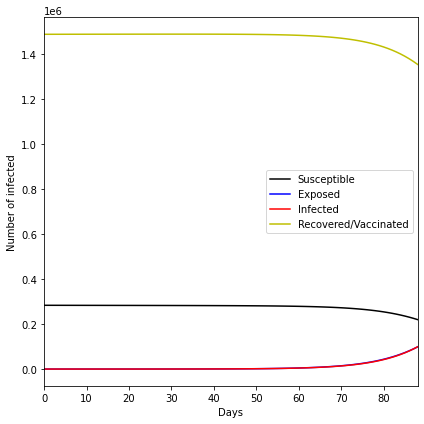

In [19]:
plotting(y)

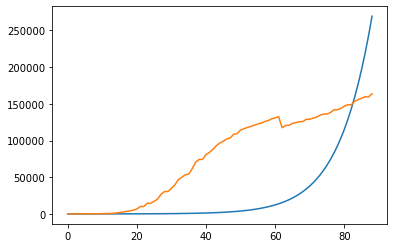

In [20]:
#plotting(y)
plt.plot(day_infs)
plt.plot(list(om.iloc[0]))

Now try and minimise SME and see what happens

In [21]:
cases = list(om.iloc[0])
len(day_infs) == len(cases)

True

In [22]:
def mean_squared_error(day_infs,cases):
    sme = 0
    try:
        for i in range(len(day_infs)):
            sme += (day_infs[i] - cases[i])**2
        return sme
    except OverflowError:
        return np.inf

In [23]:
alphas = [0.05+0.015*i for i in range(40)]

SME = []
for a in alphas:
    # [alpha, beta, gamma, omega, mu]
    params = [a, 1/5.2, 1/12,0.6*a,0.0001]
    y, day_infs = dynamics(x_init,days, params,steps)
    
    SME.append(mean_squared_error(day_infs,cases))
            

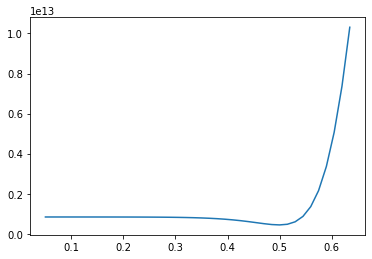

In [24]:
plt.plot(alphas,SME)

In [25]:
SME.index(min(SME))

30

In [26]:
alphas[30]

0.49999999999999994

Clearly isn't working (look at the plot for alpha 0.5). Going to try seperating the removed and vaccinated compartments

In [27]:
# Defne the SER model equatons (note the dvson by populaton as the key dfference from the contnuous case, 
# as well as dong the ncomng/outgong populatons later)
def seir(params,x,popn):
    xdot = list(np.zeros(5))
    xdot[0] = -params[0]*x[0]*x[2]/popn - params[4]*x[0]   # Susceptible
    xdot[1] = params[0]*x[0]*x[2]/popn  - params[1]*x[1]  + params[3]*x[3]*x[2]/popn # Exposed
    xdot[2] = params[1]*x[1] - params[2]*x[2] # Infected
    xdot[3] = params[4]*x[0] - params[3]*x[3]*x[2]/popn # Vaccinated
    xdot[4] = params[2]*x[2] # Removed
    
    infected_daily = params[0]*x[0]*x[2]/popn + params[3]*x[3]*x[2]/popn
    return xdot, infected_daily

In [28]:
# The big one
def dynamics(x_init,days,params,steps):
    x = [x_init] #Initial values for all towns!
    day_infs = [0]
    
    # Iterate over each day
    for day in range(days):
        #print(day)
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        for t in range(steps):
            xdot, infected_daily = seir(params, x[-1], popn)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
            day_infs.append(infected_daily+day_infs[-1])
        
    return x, day_infs

In [29]:
def plotting(y):
    s = list(zip(*y))
    plt.figure(figsize = (6,6))
    #plt.plot(s[0],'k', label ='Susceptible')
    #plt.plot(s[1],'b', label = 'Exposed')
    plt.plot(s[2],'r', label = 'Infected')
    #plt.plot(s[3],'y', label = 'Vaccinated')
    #plt.plot(s[4],'orange', label = 'Recovered')
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Number of infected")
    plt.xlim([0,steps*days])
    plt.tight_layout()

In [30]:
# Set the initial town values (when doing final simulations make sure this is accurate)
popn = 1771000
x_init = [popn*0.16,0,8,popn*0.84 - 8,0]

# Set number of days for this simulation
days = 88

# [alpha, beta, gamma, omega, mu]
params = [0.4, 1/5.2, 1/12,0.8*0.4,0]

steps = 1

# Call the function (just once)
y, day_infs = dynamics(x_init,days, params,steps)

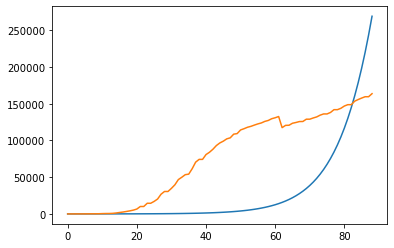

In [31]:
#plotting(y)
plt.plot(day_infs)
plt.plot(list(om.iloc[0]))

Now try and minimise SME and see what happens

In [32]:
cases = list(om.iloc[0])
len(day_infs) == len(cases)

True

In [33]:
def mean_squared_error(day_infs,cases):
    sme = 0
    try:
        for i in range(len(day_infs)):
            sme += (day_infs[i] - cases[i])**2
        return sme
    except OverflowError:
        return np.inf

In [34]:
alphas = [0.05+0.05*i for i in range(40)]

SME = []
for a in alphas:
    # [alpha, beta, gamma, omega, mu]
    params = [a, 1/5.2, 1/12,0.8*a,0]
    y, day_infs = dynamics(x_init,days, params,steps)
    
    SME.append(mean_squared_error(day_infs,cases))
            

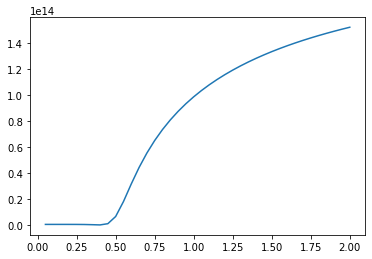

In [35]:
plt.plot(alphas,SME)

In [36]:
SME.index(min(SME))

7

In [37]:
alphas[7]

0.4

Next attempt: consider the first 40 days as different from the next days. Find the two optimal alphas based on that.

In [38]:
# Defne the SER model equatons (note the dvson by populaton as the key dfference from the contnuous case, 
# as well as dong the ncomng/outgong populatons later)
def seir(params,x,popn):
    xdot = list(np.zeros(5))
    xdot[0] = -params[0]*x[0]*x[2]/popn - params[4]*x[0]   # Susceptible
    xdot[1] = params[0]*x[0]*x[2]/popn  - params[1]*x[1]  + params[3]*x[3]*x[2]/popn # Exposed
    xdot[2] = params[1]*x[1] - params[2]*x[2] # Infected
    xdot[3] = params[4]*x[0] - params[3]*x[3]*x[2]/popn # Vaccinated
    xdot[4] = params[2]*x[2] # Removed
    
    infected_daily = params[0]*x[0]*x[2]/popn + params[3]*x[3]*x[2]/popn
    return xdot, infected_daily

In [39]:
# The big one
def dynamics(x_init,days,params,steps,a1,a2,o1,o2):
    x = [x_init] #Initial values for all towns!
    day_infs = [0]
    
    # Iterate over each day
    for day in range(days):
        #Step 1: try the different alphas and omegas.
        
        if day < 35:
            params[0] = a1
            params[3] = o1
        else:
            params[0] = a2
            params[3] = o2
        
        #print(day)
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        for t in range(steps):
            xdot, infected_daily = seir(params, x[-1], popn)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
            day_infs.append(infected_daily+day_infs[-1])
        
    return x, day_infs

In [40]:
def plotting(y):
    s = list(zip(*y))
    plt.figure(figsize = (6,6))
    #plt.plot(s[0],'k', label ='Susceptible')
    #plt.plot(s[1],'b', label = 'Exposed')
    plt.plot(s[2],'r', label = 'Infected')
    #plt.plot(s[3],'y', label = 'Vaccinated')
    #plt.plot(s[4],'orange', label = 'Recovered')
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Number of infected")
    plt.xlim([0,steps*days])
    plt.tight_layout()

In [41]:
# Set the initial town values (when doing final simulations make sure this is accurate)
popn = 1771000
x_init = [popn*0.16,24,8,popn*0.84 - 8,0]

# Set number of days for this simulation
days = 88

a1, a2, o1, o2 = 1.6, 0.1, 0.6000000000000001, 0.05
# a1 = 1.5
# o1 = 1.2
# a2 = 0.4
# o2 = 0.3

# [alpha, beta, gamma, omega, mu]
params = [a1, 1/5.2, 1/12,o1,0]

steps = 1

# Call the function (just once)
y, day_infs = dynamics(x_init,days, params,steps,a1,a2,o1,o2)

Text(0.5, 1.0, "Using Adelaide's outbreak to of best fit parameters")

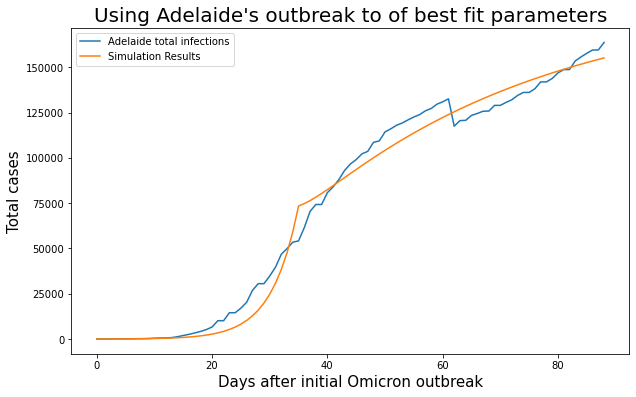

In [42]:
#plotting(y)
plt.figure(figsize = (10,6))
plt.plot(list(om.iloc[0]), label = 'Adelaide total infections')
plt.plot(day_infs, label = 'Simulation Results')
plt.ylabel('Total cases', size = 15)
plt.xlabel('Days after initial Omicron outbreak', size = 15)
plt.legend()
plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)

Now try and minimise SME and see what happens

In [43]:
cases = list(om.iloc[0])
len(day_infs) == len(cases)

True

In [60]:
def mean_squared_error(day_infs,cases):
    sme = 0
    try:
        for i in range(len(day_infs)):
            sme += (day_infs[i] - cases[i])**2
        return sme
    except OverflowError:
        return np.inf

In [85]:
alphas1 = [0.05+0.05*i for i in range(40)]
alphas2 = [0.05+0.05*i for i in range(40)]
omegas1 = [0.05+0.05*i for i in range(40)]
omegas2 = [0.05+0.05*i for i in range(40)]

SME = []
for a1 in alphas1:
    print(a1)
    for a2 in alphas2:
        for o1 in omegas1:
            if o1 < a1:
                for o2 in omegas2:
                    if o2 < a2:
                        # [alpha, beta, gamma, omega, mu]
                        params = [a1, 1/5.2, 1/12,o1,0]
                        y, day_infs = dynamics(x_init,days,params,steps,a1,a2,o1,o2)

                        SME.append([(a1,a2,o1,o2),mean_squared_error(day_infs,cases)])
            

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0


In [86]:
scores = list(zip(*SME))[1]
scores.index(min(scores))

362711

In [87]:
SME[362711]

[(1.6, 0.1, 0.6000000000000001, 0.05), 4084285592.8892503]

More improvements- change parameters to more closely reflect omicron.

https://www.medrxiv.org/content/10.1101/2022.01.04.22268721v1.full.pdf - this paper claims that latent period is 3 days and infectious period only 2.5 (ie maybe amount of time until they're removed from the population?)

This website https://www1.racgp.org.au/newsgp/clinical/how-does-omicron-compare-with-delta#:~:text=The%20incubation%20period%20of%20Omicron,or%20two%20before%20symptoms%20emerge also claims it's around 3 days, but not sure how solid of a reference it is. It also says the recovery time is around 5 days.

In [58]:
# Defne the SER model equatons (note the dvson by populaton as the key dfference from the contnuous case, 
# as well as dong the ncomng/outgong populatons later)
def seir(params,x,popn):
    xdot = list(np.zeros(5))
    xdot[0] = -params[0]*x[0]*x[2]/popn - params[4]*x[0]   # Susceptible
    xdot[1] = params[0]*x[0]*x[2]/popn  - params[1]*x[1]  + params[3]*x[3]*x[2]/popn # Exposed
    xdot[2] = params[1]*x[1] - params[2]*x[2] # Infected
    xdot[3] = params[4]*x[0] - params[3]*x[3]*x[2]/popn # Vaccinated
    xdot[4] = params[2]*x[2] # Removed
    
    infected_daily = params[0]*x[0]*x[2]/popn + params[3]*x[3]*x[2]/popn
    return xdot, infected_daily

In [59]:
# The big one
def dynamics(x_init,days,params,steps,a1,a2,o1,o2):
    x = [x_init] #Initial values for all towns!
    day_infs = [0]
    
    # Iterate over each day
    for day in range(days):
        #Step 1: try the different alphas and omegas.
        
        if day < 35:
            params[0] = a1
            params[3] = o1
        else:
            params[0] = a2
            params[3] = o2
        
        #print(day)
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        for t in range(steps):
            xdot, infected_daily = seir(params, x[-1], popn)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
            day_infs.append(infected_daily+day_infs[-1])
        
    return x, day_infs

In [60]:
def plotting(y):
    s = list(zip(*y))
    plt.figure(figsize = (6,6))
    #plt.plot(s[0],'k', label ='Susceptible')
    #plt.plot(s[1],'b', label = 'Exposed')
    plt.plot(s[2],'r', label = 'Infected')
    #plt.plot(s[3],'y', label = 'Vaccinated')
    #plt.plot(s[4],'orange', label = 'Recovered')
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Number of infected")
    plt.xlim([0,steps*days])
    plt.tight_layout()

In [77]:
# Set the initial town values (when doing final simulations make sure this is accurate)
popn = 1771000
x_init = [popn*0.16,50,8,popn*0.84 - 8,0]

# Set number of days for this simulation
days = 88

a1, a2, o1, o2 = 1.6500000000000001, 0.6500000000000001, 0.8500000000000001, 0.25
# a1 = 1.5
# o1 = 1.2
# a2 = 0.4
# o2 = 0.3

# [alpha, beta, gamma, omega, mu]
params = [a1, 1/3, 1/2.5,o1,0]

steps = 1

# Call the function (just once)
y, day_infs = dynamics(x_init,days, params,steps,a1,a2,o1,o2)

Text(0.5, 1.0, "Using Adelaide's outbreak to of best fit parameters")

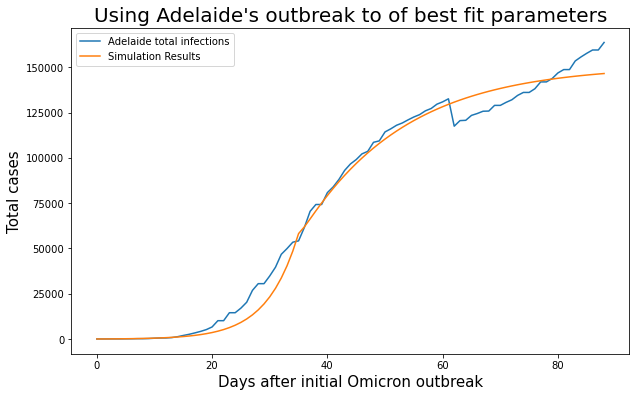

In [78]:
#plotting(y)
plt.figure(figsize = (10,6))
plt.plot(list(om.iloc[0]), label = 'Adelaide total infections')
plt.plot(day_infs, label = 'Simulation Results')
plt.ylabel('Total cases', size = 15)
plt.xlabel('Days after initial Omicron outbreak', size = 15)
plt.legend()
plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)

Now try and minimise SME and see what happens

In [63]:
cases = list(om.iloc[0])
len(day_infs) == len(cases)

True

In [64]:
def mean_squared_error(day_infs,cases):
    sme = 0
    try:
        for i in range(len(day_infs)):
            sme += (day_infs[i] - cases[i])**2
        return sme
    except OverflowError:
        return np.inf

In [72]:
alphas1 = [0.05+0.1*i for i in range(40)]
alphas2 = [0.05+0.1*i for i in range(40)]
omegas1 = [0.05+0.1*i for i in range(40)]
omegas2 = [0.05+0.1*i for i in range(40)]

SME = []
for a1 in alphas1:
    print(a1)
    for a2 in alphas2:
        for o1 in omegas1:
            if o1 < a1:
                for o2 in omegas2:
                    if o2 < a2:
                        # [alpha, beta, gamma, omega, mu]
                        params = [a1, 1/3, 1/2.5,o1,0]
                        y, day_infs = dynamics(x_init,days,params,steps,a1,a2,o1,o2)

                        SME.append([(a1,a2,o1,o2),mean_squared_error(day_infs,cases)])
            

0.05
0.15000000000000002
0.25
0.35000000000000003
0.45
0.55
0.6500000000000001
0.7500000000000001
0.8500000000000001
0.9500000000000001
1.05
1.1500000000000001
1.2500000000000002
1.35
1.4500000000000002
1.55
1.6500000000000001
1.7500000000000002
1.85
1.9500000000000002
2.05
2.15
2.25
2.35
2.45
2.55
2.65
2.75
2.85
2.95
3.05
3.15
3.25
3.35
3.45
3.55
3.65
3.75
3.85
3.95


In [73]:
scores = list(zip(*SME))[1]
scores.index(min(scores))

93890

In [74]:
SME[93890]

[(1.6500000000000001, 0.6500000000000001, 0.8500000000000001, 0.25),
 3904219055.850692]

More improvements- look at what the actual day that there seemed to be an increase in restrictions and use that as the piecewise day. Maybe also try not to fit the first 10 days, and run it again with greater granularity of parameters?